# Intermediate Ray (part 2) - XGBoost and Ray Tune

[Ray](https://docs.ray.io/en/latest/index.html) has a rich ecosystem of libraries and frameworks for Machine Learning.
These are built on top of the simple primitives provided by [Ray Core](https://docs.ray.io/en/latest/ray-core/walkthrough.html),
and the fundamental concepts were covered in the first workshops in the series (see `1-Beginner-Ray-Core.ipynb` and `2-Intermediate-Ray-Core-And-Large-Data.ipynb`).

This notebook will begin exploring that rich ecosystem of libraries with [XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) and [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).
It assumes familiarity with XGBoost and the concepts of hyperparameter tuning,
and will focus on how to integrate with Ray to distribute and scale.

Both XGBoost and the built-in Ray Tune are considered "level 3" integrations,
which are the libraries "most integrated" with Ray.
The [blog post](https://www.anyscale.com/blog/ray-distributed-library-patterns) describing the levels of integration is great reading for getting a deeper understanding of the overall ecosystem.

In this notebook we will cover:
* Baseline code for XGBoost without Ray
* XGBoost integrated with Ray
    * Distributed data loading
    * Distributed training
* Ray Tune with XGBoost integration
    * Specifying resources
    * Defining a search space
    * Defining a training function
    * Running trials
    * Analyzing results
* Bonus: non-integrated XGBoost with Ray Tune

## Sample problem: predict housing prices

We will be using a the sample California housing dataset built into scikit-learn, and training a regression model to predict median house prices.

### Get and format data

We will first load the data from scikit-learn, split into training/validation/test sets,
then save it into various formats to explore different data loading strategies.
* Each subset (training/validation/test) will be saved to a single `csv` file.
* Training and validation data will also be split into `n_files` separate `csv` files to enable distributed data loading.
* All files will be saved to a Domino Dataset.

To simulate good practices for working with large data, you're encouraged to mount the Dataset from the main copy of this tutorial project rather than saving your own copy of the data.
The below cells will define all the necessary paths and lists of files, and will not recreate the data unless the `save_ca_data` function is run.

In [1]:
import os
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
# If mounting the data from another project,
# be sure to set this data_root variable to the correct mounted dataset path.
# data_root = f"/domino/datasets/local/{os.environ['DOMINO_PROJECT_NAME']}"
data_root = "/domino/datasets/local/CA-Housing"
n_files = 4

train_file = os.path.join(data_root, "ca_train.csv")
val_file = os.path.join(data_root, "ca_val.csv")
test_file = os.path.join(data_root, "ca_test.csv")

# Also save multi-file versions of training  and validation data
train_files = [os.path.join(data_root, f"ca_train_{i}.csv") 
               for i in range(n_files)]
val_files = [os.path.join(data_root, f"ca_val_{i}.csv") 
             for i in range(n_files)]

# These variables will be used in later sections
target_col = "MedHouseVal"
model_dir = "3-Intermediate-XGB-models" # relative path, in /mnt
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [3]:
# Load CA Housing Data from sklearn
def save_cadata_chunks(n_files):
    ca_data_df = fetch_california_housing(as_frame=True).frame
    print(f"Data has {ca_data_df.shape} total rows, columns")

    # Split off and save test data
    train_val_data, test_data = train_test_split(ca_data_df, test_size=0.2, 
                                                 random_state=42)
    print(f"Saving test data with {test_data.shape[0]} rows to {test_file}")
    test_data.to_csv(test_file, index=False)

    # Split and save training and validation data
    train_data, val_data = train_test_split(train_val_data, test_size=0.3, 
                                            random_state=42)
    print(f"Saving training data with {train_data.shape[0]} \
          rows to {train_file}")
    train_data.to_csv(train_file, index=False)
    print(f"Saving validation data with {val_data.shape[0]} \
          rows to {val_file}")
    val_data.to_csv(val_file, index=False)

    # Further split and save training and validation data 
    # to n_files files each
    train_data_split = np.array_split(train_data, n_files)
    val_data_split = np.array_split(val_data, n_files)
    for i in range(n_files):
        print(f"Saving {train_data_split[i].shape[0]} \
              training rows to {train_files[i]}")
        train_data_split[i].to_csv(train_files[i], index=False) 
        print(f"Saving {val_data_split[i].shape[0]} \
              validation rows to {val_files[i]}")
        val_data_split[i].to_csv(val_files[i], index=False)
    print("Done!")

In [4]:
# No need to actually run this again if mounting the dataset
# save_cadata_chunks(n_files)

Data has (20640, 9) total rows, columns
Saving test data with 4128 rows to /domino/datasets/local/ray-tutorial/ca_test.csv
Saving training data with 11558           rows to /domino/datasets/local/ray-tutorial/ca_train.csv
Saving validation data with 4954           rows to /domino/datasets/local/ray-tutorial/ca_val.csv
Saving 2890               training rows to /domino/datasets/local/ray-tutorial/ca_train_0.csv
Saving 1239               validation rows to /domino/datasets/local/ray-tutorial/ca_val_0.csv
Saving 2890               training rows to /domino/datasets/local/ray-tutorial/ca_train_1.csv
Saving 1239               validation rows to /domino/datasets/local/ray-tutorial/ca_val_1.csv
Saving 2889               training rows to /domino/datasets/local/ray-tutorial/ca_train_2.csv
Saving 1238               validation rows to /domino/datasets/local/ray-tutorial/ca_val_2.csv
Saving 2889               training rows to /domino/datasets/local/ray-tutorial/ca_train_3.csv
Saving 1238           

In [5]:
# Check that the files are available as expected
all_files = train_files.copy()
all_files.extend(val_files)
all_files.extend([train_file, val_file, test_file])
for f in all_files:
    assert os.path.isfile(f)

In [6]:
!ls $data_root

ca_test.csv	ca_train.csv  ca_val.csv	  points_3e6.parquet
ca_train_0.csv	ca_val_0.csv  points_1e6.parquet  points_3e7.parquet
ca_train_1.csv	ca_val_1.csv  points_1e7.parquet  points_3e7_split10
ca_train_2.csv	ca_val_2.csv  points_1e8.parquet  points_3e8_split30
ca_train_3.csv	ca_val_3.csv  points_1e8_split10


## Baseline: XGBoost without Ray

Before involving our Ray cluster, let's train a model with plain [XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) as a baseline.
Keep the following in mind to compare with the later Ray versions of the code:
* We are importing `xgboost` as `xgb`
* We read in the data as regular Pandas dataframes.
* There are two different APIs available for XGBoost:
    * The native API using `xgb.train`
    * The scikit-learn API wrapper using `xgb.XGBRegressor`
* XGBoost can make use of some parallelism even outside Ray, with `njobs` or `nthreads` parameters.
* We are setting a few [hyperparameters]( https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters) explicitly here, to specific values.

In [7]:
from sklearn.metrics import mean_absolute_error
import pandas as pd
import xgboost as xgb

In [8]:
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

X_train = train_data.drop(target_col, axis=1)
y_train = train_data[target_col]
X_test = test_data.drop(target_col, axis=1)
y_test = test_data[target_col]

### XGBoost scikit-learn API wrapper

The scikit-learn API is a wrapper around core XGboost functionality,
and is a familiar interface for many data scientists, so it is a good place to start.

In [9]:
# Initialize the model, setting a few hyperparameters to specific values
xgb_model = xgb.XGBRegressor(
    n_jobs=1,
    random_state=42,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=50,
    eval_metric='mae'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Serialize the model
xgb_model.save_model(os.path.join(model_dir, "plain_sklearn.xgb"))
print(f"Model object type: {type(xgb_model)}")

Model object type: <class 'xgboost.sklearn.XGBRegressor'>


MAE: 0.4039994703799625


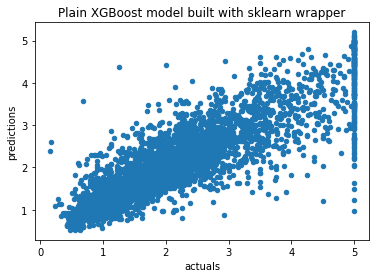

In [10]:
# Load the serialized model
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(os.path.join(model_dir, "plain_sklearn.xgb"))

# Make predictions on the test data
predictions = xgb_model.predict(X_test)
actuals = y_test
print(f"MAE: {mean_absolute_error(actuals, predictions)}")
pd.DataFrame.from_dict({"actuals": actuals, "predictions": predictions}).plot.scatter(
    x="actuals", y="predictions", title="Plain XGBoost model built with sklearn wrapper");

### XGBoost native API

Using XGBoost directly has a slightly different structure.
* Some parameters are named differently and/or have different default values.
* Data is passed via `xgb.DMatrix` rather than pandas dataframes
* The model object has a different type, and loads the serialized model object differently

In [11]:
# Set a few hyperparameters to specific values
param = {
    'nthread':1,
    'seed':42,
    'max_depth':3,
    'eta':0.1,
    'eval_metric':'mae'
}

# Train the model
bst = xgb.train(
    param,
    xgb.DMatrix(X_train, y_train),
    num_boost_round=50,
    verbose_eval=False,
)

# Serialize the model
bst.save_model(os.path.join(model_dir, "plain_native.xgb"))
print(f"Model object type: {type(bst)}")

Model object type: <class 'xgboost.core.Booster'>


MAE: 0.4039994703799625


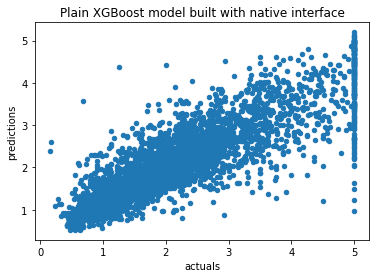

In [12]:
# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(model_dir, "plain_native.xgb"))

# Make predictions on the test data
predictions = bst.predict(xgb.DMatrix(X_test, y_test))
actuals = y_test
print(f"MAE: {mean_absolute_error(actuals, predictions)}")
pd.DataFrame.from_dict({"actuals": actuals, "predictions": predictions}).plot.scatter(
    x="actuals", y="predictions", title="Plain XGBoost model built with native interface");

## XGBoost in Ray

Our data set is small, but what if it was too large to effectively train on a single machine?
What if the training times are very long?
Ray comes to the rescue!

Now we will import a new [library](https://github.com/ray-project/xgboost_ray), `xgboost_ray`, which allows distributing XGBoost model training on a Ray cluster.
Notice the following similarities and differences to the non-Ray baseline code above:
* We are importing a `xgboost_ray` as `xgbr`.
* We can still use either the native XGBoost style API or the scikit-learn style wrapper
* We read in the data differently - this is a very important change!
* We set the parallelism in a different way to distribute work on the Ray cluster
* Nothing has really changed in how we set the hyperparameters (yet - this will come when we introduce Ray Tune)

In [13]:
import ray
import os
from sklearn.metrics import mean_absolute_error
import xgboost_ray as xgbr
import modin.pandas as mpd

#ray.shutdown()

if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

### Distributed data loading

In practice, this is one of the most important steps to get right when scaling to large data.
The `xgboost_ray` library uses the `RayDMatrix` instead of `DMatrix` to load data,
and [it has a lot of options](https://github.com/ray-project/xgboost_ray#data-sources) for distributed data loading.
The most important things to keep in mind are:
* Similar to Ray Data, the `RayDMatrix` is limited in parallelism by the number of input files being loaded.
    * Single or multiple csv and parquet files can be loaded directly
    * Data can be loaded via Modin dataframe (notice the import of `modin.pandas`, which was covered in the previous notebook)
    * Data can be loaded via Ray Data dataset and other methods as well. (We won't make use of Ray Data in this code, but it may be useful for certain types of last-mile processing.)
* Data read into the `RayDMatrix` should be fully ready for training or validation, with no remaining pre-processing.
    * Passing data to a `RayDMatrix` is a "one-way" operation - you can convert from many file and object formats to a `RayDMatrix`, but you cannot convert back.
    * The target column must be specified when passing the data.
* A `RayDMatrix` uses *lazy* loading, and will not actually read data until needed for training.

In [14]:
# Read in data directly to RayDMatrix from a list of files
# Notice that the files are already separated into training and validation sets
rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

In [15]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

# This function verifies whether the data will support splitting into a given number of shards.
# Try this with n_files+1 and see the error that results.
rdm_train.assert_enough_shards_for_actors(n_files)

In [16]:
print(f"Will the read be distributed? {rdm_train.distributed}")
print(f"Has any data been read yet? {rdm_train.loaded}")

Will the read be distributed? True
Has any data been read yet? False


In [17]:
# We will read the test data using Modin, to demonstrate another option for loading.
# This will also be convenient when plotting predictions vs actuals as in previous sections

mdf_test = mpd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(mdf_test, label=target_col)
print(f"Will the read from Modin be distributed? {rdm_test.distributed}")

Will the read from Modin be distributed? True


### Distributed training with scikit-learn API wrapper

This is nearly identical to the non-Ray code, except for the following
* The n_jobs parameter now controls number of Ray Actors.
    * Note that it will generate an error if you request more actors than the data can be sharded for.
* The model object is a different type, from the `xgboost_ray` library.
* The data is passed via a single `RayDMatrix` object, instead of `X` and `y` pandas objects.

In [18]:
# Initialize the model, setting a few hyperparameters to specific values
xgbr_model = xgbr.RayXGBRegressor(
    n_jobs=3,
    random_state=42,
    max_depth=3,
    learning_rate=0.1,
    n_estimators=50,
    eval_metric='mae'
)

# Train the model
xgbr_model.fit(rdm_train, None)

# Serialize the model
xgbr_model.save_model(os.path.join(model_dir, "ray_sklearn.xgb"))
print(f"Model object type: {type(xgbr_model)}")

(_wrapped pid=5721) 2023-02-02 17:40:45,400	INFO main.py:985 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=5721) 2023-02-02 17:40:47,109	INFO main.py:1030 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=1702, ip=10.0.36.194) [17:40:47] task [xgboost.ray]:139878199794992 got new rank 0
(_RemoteRayXGBoostActor pid=757, ip=10.0.40.94) [17:40:47] task [xgboost.ray]:139897392831696 got new rank 1
(_RemoteRayXGBoostActor pid=5752) [17:40:47] task [xgboost.ray]:140229896506336 got new rank 2


Model object type: <class 'xgboost_ray.sklearn.RayXGBRegressor'>


(_wrapped pid=5721) 2023-02-02 17:40:47,898	INFO main.py:1509 -- [RayXGBoost] Finished XGBoost training on training data with total N=11,558 in 4.14 seconds (0.79 pure XGBoost training time).
(predict pid=5721) 2023-02-02 17:40:48,225	INFO main.py:1549 -- [RayXGBoost] Created 3 remote actors.
(predict pid=5721) 2023-02-02 17:40:53,705	INFO main.py:1566 -- [RayXGBoost] Starting XGBoost prediction.


MAE: 0.39935954362601966


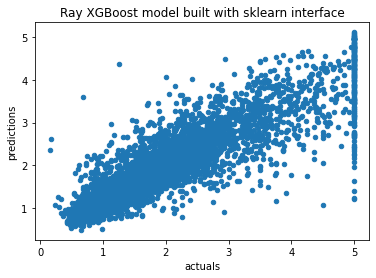

In [19]:
# Load the serialized model
xgbr_model = xgbr.RayXGBRegressor()
xgbr_model.load_model(os.path.join(model_dir, "ray_sklearn.xgb"))

# Make predictions on the test data
predictions = xgbr_model.predict(rdm_test)
actuals = mdf_test[target_col]
print(f"MAE: {mean_absolute_error(actuals, predictions)}")
pd.DataFrame.from_dict({"actuals": actuals, "predictions": predictions}).plot.scatter(
    x="actuals", y="predictions", title="Ray XGBoost model built with sklearn interface");

### Distributed training with XGBoost native API
Again there are only small differences compared to the non-Ray code
* Instead of the `nthreads` argument, we now pass a `RayParams` object to control number of Actors.
* We pass the data via `RayDMatrix` objects.
* Predictions are done using `xgboost_ray.predict` instead of the Booster object `predict` function.
    * The model object here is *not* a different type - a normal `xgboost` Booster object is returned. This object does not know how to make predictions on a `RayDMatrix`.

In [20]:
# Set a few hyperparameters to specific values
param = {
    'seed':42,
    'max_depth':3,
    'eta':0.1,
    'eval_metric':'mae'
}

xgb_ray_params = xgbr.RayParams(
    num_actors=2,
    cpus_per_actor=1
)

# Train the model
evals_result = {}
bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=False,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

# Serialize the model
bst.save_model(os.path.join(model_dir, "ray_native.xgb"))
print(f"Model object type: {type(bst)}")

(_wrapped pid=6093) 2023-02-02 17:40:57,148	INFO main.py:985 -- [RayXGBoost] Created 2 new actors (2 total actors). Waiting until actors are ready for training.
(_wrapped pid=6093) 2023-02-02 17:40:58,956	INFO main.py:1030 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=1872, ip=10.0.36.194) [17:40:59] task [xgboost.ray]:139828764693744 got new rank 0
(_RemoteRayXGBoostActor pid=6157) [17:40:59] task [xgboost.ray]:140045280281360 got new rank 1


Model object type: <class 'xgboost.core.Booster'>


We have also added the `evals_result` and `evals` arguments, so that the model will be evaluated against both training and validation data.
This is not specific to the Ray version of XGBoost (except that the `evals` argument accepts `RayDMatrix` instead of `DMatrix`).
We will be using it more when we introduce Ray Tune, but let's inspect the results now to get familiar.

In [21]:
print(f"Last 3 rounds training MAE: {evals_result['train']['mae'][-3:]}")
print(f"Last 3 rounds validation MAE: {evals_result['val']['mae'][-3:]}")

Last 3 rounds training MAE: [0.39514803591690834, 0.3925108027939855, 0.3915360653316878]
Last 3 rounds validation MAE: [0.4047519665333259, 0.40229560276000886, 0.4014341846186642]


(_wrapped pid=6093) 2023-02-02 17:40:59,843	INFO main.py:1509 -- [RayXGBoost] Finished XGBoost training on training data with total N=11,558 in 4.39 seconds (0.88 pure XGBoost training time).
(predict pid=6093) 2023-02-02 17:40:59,918	INFO main.py:1549 -- [RayXGBoost] Created 2 remote actors.
(predict pid=6093) 2023-02-02 17:41:05,398	INFO main.py:1566 -- [RayXGBoost] Starting XGBoost prediction.


MAE: 0.4010873359413295


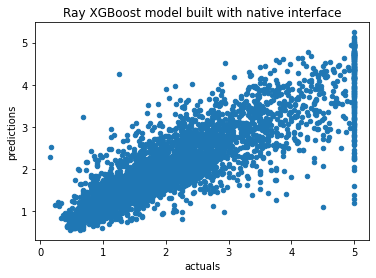

In [22]:
# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(model_dir, "ray_native.xgb"))

# Make predictions on the test data
#predictions = bst.predict(rdm_test) # cannot do this because "bst" is not Ray-aware
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
actuals = mdf_test[target_col]
print(f"MAE: {mean_absolute_error(actuals, predictions)}")
pd.DataFrame.from_dict({"actuals": actuals, "predictions": predictions}).plot.scatter(
    x="actuals", y="predictions", title="Ray XGBoost model built with native interface");

# Ray Tune

We've seen how to do distributed training of a single XGBoost model on a Ray cluster.
Now, let's introduce the [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) library for hyperparameter tuning.
Even when a single model can be trained reasonably without a cluster,
training many copies of the model for hyperparameter tuning can be prohibitively slow.
Ray Tune integrates especially well with XGBoost and certain other libraries,
but it can be used with almost any machine learning library.

In the next few sections we'll set up a basic example.
In addition, the [Key Concepts page](https://docs.ray.io/en/latest/tune/key-concepts.html#tune-60-seconds) of the Ray Tune documentation is highly recommended reading.
There are some structural changes to the Tune API in Ray 2.0, but the concepts remain very similar.

In [23]:
from ray import tune

## Resources per Trial

Hyperparameter tuning requires training many copies of a model,
each with a different set of hyperparameters,
and seeing which one performs the best.
Each time we train a model, that is one *trial*.
To do this in our Ray cluster, we can specify what resources to use:
* Required CPU, Memory, and/or GPU *per trial*
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training.
Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`.
As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

Note that Ray Tune will stall if the requested resources are not available.
Since autoscaling in Domino is based on actual resource usage, not pending assignments in the Ray cluster, a Domino cluster will NOT autoscale (even if autoscaling is enabled) to accommodate a larger resource request.

In [24]:
# Define the resources we want to use per trial (i.e. per XGBoost training run)
xgb_ray_params = xgbr.RayParams(num_actors=2, cpus_per_actor=1)

# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.utils.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 3.0} per trial.
The cluster has 18.0 CPU total.


By default, Ray Tune places intermediate results is `~/results-dir`, which is generally `/home/ubuntu/results-dir` in Domino.
This path is not accessible to Ray workers in Domino, so it is necessary to specify a different location.
There are two possible options:
* Put results in the `/tmp` dir (backed by share storage, or dedicated local storage if enabled).
    * This will be temporary, cleared any time the cluster stops.
    * It is not directly accessible from the workspace
* Put results in a dataset, e.g. `/domino/datasets/local/Ray-Tutorial`.
    * This will be persistent between workspace sessions - you must clear old results yourself to avoid unnecessary storage usage.
    * It is directly accessible from the workspace, and from any workspace in the project.

The second option is generally more convenient, but requires some care to avoid clutter for yourself or your collaborators.

In [25]:
# Place results in a subfolder under the default project dataset
tune_local_dir = os.path.join("/domino/datasets/local", os.environ["DOMINO_PROJECT_NAME"], "ray_results")
print(f"Saving intermediate tune results to {tune_local_dir}")

Saving intermediate tune results to /domino/datasets/local/ray-tutorial/ray_results


## Defining a hyperparameter search space

The simplest search is a grid search across a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it.
However, for `n` choices each of `k` hyperparameters, a full grid search requires `O(n^k)` trials and  quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization.
Instead of pre-defining a fixed grid to search over,
Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters.

The total number of trials is defined separately,
and hyperparameters for each trial are drawn from this search space according to the [search algorithm](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms).
Ray Tune can integrate with many popular optimization libraries, but we will stick with the default Random Grid Search for now and not explicitly specify the algorithm to use.

In [26]:
# Note the config object is just an ordinary dictionary
# It can include fixed parameters as well as Ray Tune search space definitions
config = {
    "seed": 42,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "eval_metric": "mae"
}

## Defining a training function

For each trial, a `config` dictionary like the one we just defined,
with the single value for each hyperparameter chosen for that trial,
will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune.
Below we have defined such a function to wrap training a single XGBoost model on Ray.
* This function must accept the `config` we defined as input.
* It must report results back to Ray Tune - the `xgboost_ray` library takes care of this automatically!
    * Notice the `evals` we are passing; these will determine what metrics are reported
* Any checkpoints saved (like the `model.xgb` below) will be saved to `tune_local_dir`.

Notice that we are referencing three global variables below: `rdm_train`, `rdm_val`, and `xgb_ray_params`.
This can be convenient to do when writing complicated training functions in a notebook,
but is a somewhat risky practice in general.
Be **very careful** to avoid referencing large amounts of data directly like this;
our data is wrapped in a `RayDMatrix` with lazy loading, so this works for our case,
but e.g. plain dataframes should NOT be referenced this way.

In [27]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the Tune results folder

## Running the trials

Finally, we can now run our trials!
Here we bring together the previous few sections:
* The training function
* The search space defined in the config
* The resources per trial and results location

We also specify a few more important items:
* The metric must be something that is reported by the training function.
    * This is where the `evals` passed to XGBoost come in; it will automatically report metrics where the prefix is the name given in the `evals`, and the suffix is the `eval_metric`. So, in our case we can choose either `train-mae` or `val-mae`.
    * The metric can be either minimized (error metrics) or maximized (accuracy metrics) - be sure to specify the correct mode.
* The `num_samples` controls the number of trials.

There are many other options that can be specified, such as functions for early stopping, but we won't explore all of them here.
We do include two very convenient options for controlling the output of the tuning run, the `verbosity` (which defaults to 3, the most verbose) and the `progress_reporter`.
You may prefer to leave the verbosity at maximum and use the default progress reporter when first developing your code, as this gives the most thorough record of warnings and errors.
Less verbose output that is overwritten at each update is usually more convenient in the long run.

In [28]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=tune_local_dir,
    metric="val-mae",
    mode="min",
    num_samples=4,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

Trial name,status,loc,eta,max_depth,iter,total time (s),train-mae,val-mae
my_trainer_da3c8_00000,TERMINATED,10.0.46.72:6514,0.0192792,2,50,3.50207,0.753203,0.762669
my_trainer_da3c8_00001,TERMINATED,10.0.40.94:1035,0.0552829,3,50,4.01011,0.454477,0.461402
my_trainer_da3c8_00002,TERMINATED,10.0.36.194:1982,0.00386366,4,50,3.7786,1.30028,1.31021
my_trainer_da3c8_00003,TERMINATED,10.0.36.194:1983,0.0142417,3,50,3.88215,0.84686,0.857105


## Analyze results and get the best model

Ray Tune returns an [`ExperimentAnalysis` object](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#analysis) which contains the results of the trials.
We'll cover only a few of the results it contains, so you are encouraged to explore other available methods.

One of the most useful results is the directory where the best model results are stored.
* We can copy the serialized model object to our working directory for future use.
* In the event of errors, a directory like this will contain the detailed error text.
    * Try deliberately specifying an invalid metric, e.g. a typo like `metric="val-maee"`, then explore the trial directory to see how you might diagnose the problem.
* The directory is used as the "key" for various other results returned by the analysis.

In [29]:
# Hyperparameters from the best trial
analysis.best_config

{'seed': 42, 'eta': 0.05528289967989549, 'max_depth': 3, 'eval_metric': 'mae'}

In [30]:
# Directory with the best model results
analysis.best_logdir

'/domino/datasets/local/ray-tutorial/ray_results/my_trainer_2023-02-02_17-41-17/my_trainer_da3c8_00001_1_eta=0.055283,max_depth=3_2023-02-02_17-41-20'

(run pid=6437) 2023-02-02 17:41:24,771	INFO tune.py:626 -- Total run time: 7.12 seconds (6.15 seconds for the tuning loop).


In [31]:
# Copy the best model object to the same directory as our earlier models
import shutil
shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(model_dir, "tune_best.xgb")
)

'3-Intermediate-XGB-models/tune_best.xgb'

(predict pid=6437) 2023-02-02 17:41:25,190	INFO main.py:1549 -- [RayXGBoost] Created 2 remote actors.
(predict pid=6437) 2023-02-02 17:41:29,036	INFO main.py:1566 -- [RayXGBoost] Starting XGBoost prediction.
(compute_sliced_len pid=1273, ip=10.0.40.94) Exception ignored in: <module 'collections.abc' from '/home/ray/anaconda3/lib/python3.8/collections/abc.py'>
(compute_sliced_len pid=1273, ip=10.0.40.94) Traceback (most recent call last):
(compute_sliced_len pid=1273, ip=10.0.40.94)   File "<string>", line 1, in <module>
(compute_sliced_len pid=1273, ip=10.0.40.94)   File "/home/ray/anaconda3/lib/python3.8/site-packages/ray/worker.py", line 428, in sigterm_handler
(compute_sliced_len pid=1273, ip=10.0.40.94)     sys.exit(1)
(compute_sliced_len pid=1273, ip=10.0.40.94) SystemExit: 1
(compute_sliced_len pid=1273, ip=10.0.40.94) RuntimeWarning: Cython module failed to patch module with custom type
A worker died or was killed while executing a task by an unexpected system error. To troubles

MAE: 0.46435814797145913


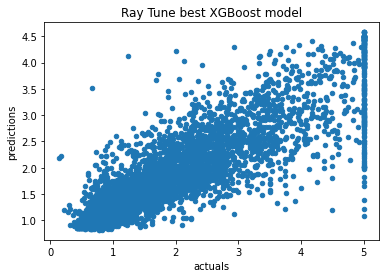

In [32]:
# Now we can make predictions, etc, just like previous sections
# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(model_dir, "tune_best.xgb"))

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
actuals = mdf_test[target_col]
print(f"MAE: {mean_absolute_error(actuals, predictions)}")
pd.DataFrame.from_dict({"actuals": actuals, "predictions": predictions}).plot.scatter(
    x="actuals", y="predictions", title="Ray Tune best XGBoost model");

In [33]:
# We can see the progress of the model over each iteration
analysis.trial_dataframes[analysis.best_logdir].head(3)

,train-mae,val-mae,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore
0,1.484835,1.494951,3.729951,False,NaN,NaN,1,da3c8_00001,b7b90b92330f40c797a93994c841613c,2023-02-02_17-41-24,1675388484,3.729951,1035,ray-63dc61b746197615f41bbb87-ray-worker-0,10.0.40.94,3.729951,0,1
1,1.404964,1.413964,0.010235,False,NaN,NaN,2,da3c8_00001,b7b90b92330f40c797a93994c841613c,2023-02-02_17-41-24,1675388484,3.740186,1035,ray-63dc61b746197615f41bbb87-ray-worker-0,10.0.40.94,3.740186,0,2
2,1.330831,1.339741,0.004795,False,NaN,NaN,3,da3c8_00001,b7b90b92330f40c797a93994c841613c,2023-02-02_17-41-24,1675388484,3.744981,1035,ray-63dc61b746197615f41bbb87-ray-worker-0,10.0.40.94,3.744981,0,3


In [34]:
# The same results are stored on disk in the progress.csv file
bst_progress = pd.read_csv(os.path.join(analysis.best_logdir, "progress.csv"))
bst_progress.head(3)

,train-mae,val-mae,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore
0,1.484835,1.494951,3.729951,False,NaN,NaN,1,da3c8_00001,b7b90b92330f40c797a93994c841613c,2023-02-02_17-41-24,1675388484,3.729951,1035,ray-63dc61b746197615f41bbb87-ray-worker-0,10.0.40.94,3.729951,0,1
1,1.404964,1.413964,0.010235,False,NaN,NaN,2,da3c8_00001,b7b90b92330f40c797a93994c841613c,2023-02-02_17-41-24,1675388484,3.740186,1035,ray-63dc61b746197615f41bbb87-ray-worker-0,10.0.40.94,3.740186,0,2
2,1.330831,1.339741,0.004795,False,NaN,NaN,3,da3c8_00001,b7b90b92330f40c797a93994c841613c,2023-02-02_17-41-24,1675388484,3.744981,1035,ray-63dc61b746197615f41bbb87-ray-worker-0,10.0.40.94,3.744981,0,3


# Bonus: Ray Tune with a non-integrated library

In the above example, we used a very well-integrated library to do our model training.
However, Ray Tune can be used with almost any library (as long as it is installed on the cluster workers).
Below we'll show an example with the "plain" version of XGBoost to see how it can be done.
There are only two major differences:
* Data is loaded into a plain `DMatrix`
    * Notice how we use `ray.put` to avoid copying the data more than necessary.
    * Another option is to read the data inside the trainer function itself.
* We must call `tune.report` from inside the trainer function to report the metric.

Notice how fast this runs on our small dataset!
It is a great example of the principle of NOT distributing a problem unless it is actually necessary.
Unless a single model actually requires distributed XGBoost to train, it is better to use Ray Tune with non-distributed training within each trial, and simply use the Ray cluster to run many trials in parallel.

In [35]:
train_data_ref = ray.put(pd.read_csv(train_file))
val_data_ref = ray.put(pd.read_csv(val_file))

In [36]:
config = {
    "seed": 42,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "eval_metric": "mae"
}

def my_plain_xgb_trainer(config):
    train_data = ray.get(train_data_ref)
    val_data = ray.get(val_data_ref)
    dm_train = xgb.DMatrix(train_data.drop(target_col, axis=1), train_data[target_col])
    dm_val = xgb.DMatrix(val_data.drop(target_col, axis=1), val_data[target_col])
    evals_result = {}
    bst = xgb.train(
        params=config,
        dtrain=dm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(dm_train, "train"), (dm_val, "val")]
    )
    bst.save_model("model.xgb") # This is gonna go into the results directory
    tune.report(manually_reported_metric=evals_result["val"]["mae"][-1])

analysis = tune.run(
    my_plain_xgb_trainer,
    config=config,
    local_dir=tune_local_dir,
    metric="manually_reported_metric",
    mode="min",
    num_samples=20,
    resources_per_trial={"cpu": 1},
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

Trial name,status,loc,eta,max_depth,iter,total time (s),manually_reported_metric
my_plain_xgb_trainer_e5080_00000,TERMINATED,10.0.40.94:1381,0.0376514,3,1,0.729845,0.526698
my_plain_xgb_trainer_e5080_00001,TERMINATED,10.0.36.194:2280,0.0305528,4,1,0.958911,0.546898
my_plain_xgb_trainer_e5080_00002,TERMINATED,10.0.36.194:2286,0.0518096,2,1,0.621203,0.543388
my_plain_xgb_trainer_e5080_00003,TERMINATED,10.0.40.94:1380,0.00581454,4,1,1.09767,1.19582
my_plain_xgb_trainer_e5080_00004,TERMINATED,10.0.40.94:1382,0.167782,3,1,0.859254,0.374012
my_plain_xgb_trainer_e5080_00005,TERMINATED,10.0.46.72:6926,0.159732,3,1,0.828103,0.381511
my_plain_xgb_trainer_e5080_00006,TERMINATED,10.0.36.194:2282,0.00484579,5,1,1.23934,1.24872
my_plain_xgb_trainer_e5080_00007,TERMINATED,10.0.40.94:1379,0.0660813,5,1,1.02213,0.378133
my_plain_xgb_trainer_e5080_00008,TERMINATED,10.0.46.72:6925,0.0106109,3,1,0.842458,0.979362
my_plain_xgb_trainer_e5080_00009,TERMINATED,10.0.40.94:1388,0.0048702,2,1,0.793807,1.25237


(run pid=6844) 2023-02-02 17:41:43,171	INFO tune.py:626 -- Total run time: 7.39 seconds (6.41 seconds for the tuning loop).


# Congratulations!

You have finished the Intermediate (part 2), where we covered the following:
* Baseline code for XGBoost without Ray
* XGBoost integrated with Ray
    * Distributed data loading
    * Distributed training
* Ray Tune with XGBoost integration
    * Specifying resources
    * Defining a search space
    * Defining a training function
    * Running trials
    * Analyzing results
* Bonus: non-integrated XGBoost with Ray Tune

## What's next?

This concludes our Ray workshop series (for now).
Try modifying the examples to apply to your projects, or explore the Ray ecosystem for other libraries!
Even if a library does not explicitly integrate with Ray, it can usually be combined with Ray Tune for hyperparameter tuning.

Remember than any packages used by the cluster must be installed on **both** the Workspace compute environment and Cluster compute environment.
Check out the `troubleshooting/check_packages.ipynb` for some helper code that will verify package versions across both environments.

There are also plenty of advanced topics to explore, and other frameworks with substantial integrations like PyTorch and other Deep Learning frameworks.
This is a fast-evolving ecosystem, so the most useful framework for you may be released between when this tutorial is written and when you are reading it!